In [ ]:
!pip install mlflow
!pip install boto3
!pip install awscli

In [ ]:
!aws configure list

      Name                    Value             Type    Location
      ----                    -----             ----    --------
   profile                <not set>             None    None
access_key     ****************DU4P shared-credentials-file    
secret_key     ****************+wZh shared-credentials-file    
    region                us-east-2      config-file    ~/.aws/config


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import userdata

AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')
AWS_DEFAULT_REGION = userdata.get('AWS_DEFAULT_REGION')

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv")
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
df = df.dropna()

In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df[df['clean_comment'].str.strip() != '']

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def remove_stopwords(text, stop_words):
        return ' '.join([word for word in text.split() if word not in stop_words])

In [ ]:
def lemmatize_comment(text):
  lemmatizer = WordNetLemmatizer()
  return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [ ]:
def preprocess_comment(comment: pd.Series) -> pd.Series:
  comment = comment.str.lower()
  comment = comment.str.replace('\n',' ')
  # remove non-alphanumeric chars
  comment = comment.str.replace(r'[^A-Za-z0-9!,\.\s]','',regex = True)
  #remove stop words but retain important ones for sentiment analysis
  stop_words = set(stopwords.words('english')) - {'not','but','however','no','yet'}
  comment = comment.apply(lambda text: remove_stopwords(text, stop_words))
  comment = comment.apply(lemmatize_comment)
  comment = comment.str.strip()
  return comment

In [ ]:
df['clean_comment'] = preprocess_comment(df['clean_comment'])

In [ ]:
df[(df['clean_comment'].str.startswith(' ')| df['clean_comment'].str.endswith(' '))]

,clean_comment,category


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlflow.models import infer_signature

In [ ]:
#Initializing the vectorizer
vectorizer = CountVectorizer(max_features=10000)

In [ ]:
!aws configure set aws_access_key_id $AWS_ACCESS_KEY_ID
!aws configure set aws_secret_access_key $AWS_SECRET_ACCESS_KEY
!aws configure set default.region $AWS_DEFAULT_REGION


In [ ]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']
y.unique()

array([ 1, -1,  0])

In [ ]:
IP = "18.217.224.164"
protocol = "http"
port = "5000"

In [ ]:
mlflow.set_tracking_uri(f"{protocol}://{IP}:{port}/")
mlflow.set_experiment("RandomForest Baseline")


2025/10/07 14:57:49 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://my-mlflow-bucket-1299/151400915374454258', creation_time=1759849069380, experiment_id='151400915374454258', last_update_time=1759849069380, lifecycle_stage='active', name='RandomForest Baseline', tags={}>

In [ ]:
X.shape

(36793, 10000)

In [ ]:
!aws s3 ls

2025-10-06 12:09:36 my-mlflow-bucket-1299


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state = 42, stratify=y)

2025/10/07 15:07:28 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    0,
    0,
    0,
    0,
    0,.... Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: Failed to enforce schema of data '[0 0 0 0 0 0 0 0 0 0]' with schema '[Tensor('int64', (-1, 10000))]'. Error: Shape of input (10,) does not match expected shape (-1, 10000).
Successfully registered model 'Random Forest Baseline Model'.
2025/10/07 15:07:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest Baseline Model, version 1
Created version '1' o

🏃 View run RandomForest Baseline Train Test split at: http://18.217.224.164:5000/#/experiments/151400915374454258/runs/df398c35a76a425e9713a002f94af460
🧪 View experiment at: http://18.217.224.164:5000/#/experiments/151400915374454258
Accuracy: 0.6481858948226661


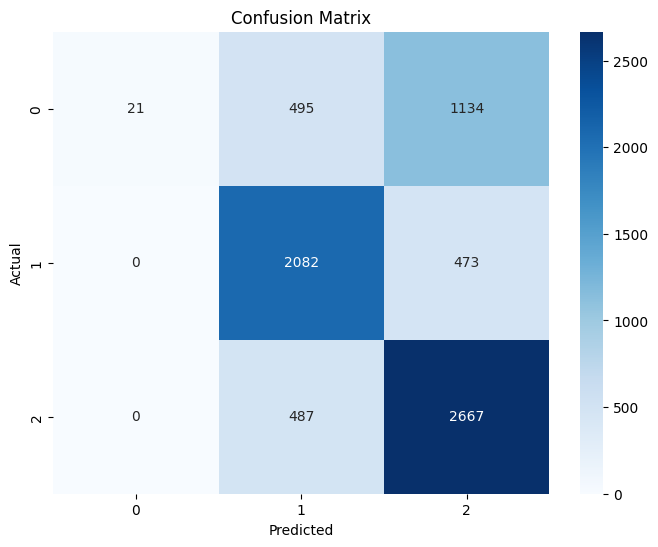

In [ ]:
with mlflow.start_run():
  mlflow.set_tag("mlflow.runName", "RandomForest Baseline Train Test split")
  mlflow.set_tag("experiment_type","baseline")
  mlflow.set_tag("model_type", "RandomForestClassifier")

  #add description
  mlflow.set_tag("description","Baseline RandomForest Model for sentiment analysis using Bag of Words")

  #log params
  mlflow.log_param("vectorizer_type", "CountVectorizer")
  mlflow.log_param("vectorizer_max_features",vectorizer.max_features)

  #Log Random Forest Parameters
  n_estimators = 200
  max_depth = 15

  #intialize and train the model
  model = RandomForestClassifier(n_estimators=n_estimators, max_depth= max_depth)
  model.fit(X_train, y_train)

  #Make predcitions
  y_pred = model.predict(X_test)

  #Log metrics for each class and accuracy
  accuracy = accuracy_score(y_test, y_pred)
  mlflow.log_metric("accuracy", accuracy)

  classification_rep = classification_report(y_test, y_pred, output_dict=True)

  for label,metrics in classification_rep.items():
    if isinstance(metrics, dict):
      for metric, value in metrics.items():
        mlflow.log_metric(f"{label}_{metric}",value)

  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize = (8,6))
  sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")

  #save and log confusiom matrix plot
  fig_name = "confusion_matrix.png"
  plt.savefig(fig_name)
  mlflow.log_artifact(f"/content/{fig_name}")

  log_model = mlflow.sklearn.log_model(
                  model,
                  name="Random_Forest_Model",
                  signature=infer_signature(X_train, y_pred),
                  registered_model_name = "Random Forest Baseline Model"
                  )

  df.to_csv("dataset.csv", index = False)
  mlflow.log_artifact("/content/dataset.csv")

print(f"Accuracy: {accuracy}")